🍁 Preprocessing

In [2]:
from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np

# Import
(x_train, y_train), (_, _) = mnist.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# 1. Flatten
x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(f"x_train_flat shape: {x_train_flat.shape}, y_train shape: {y_train.shape}")

# 2. Subsets
subset_size = 500
x_train_subset = x_train_flat[:subset_size]
y_train_subset = y_train[:subset_size]
print(f"x_train_subset shape: {x_train_subset.shape}")

# 3. PCA
n_components = 10
d = 3 # degree
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_subset)
print(f"x_train_pca shape: {x_train_pca.shape}")
variance = np.sum(pca.explained_variance_ratio_)
print(f"variance = {variance}")

# # 4. Normalize
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_train_norm = scaler.fit_transform(x_train_pca)
# print(f"x_train_norm shape: {x_train_norm.shape}")
# x_train_norm.shape[0]

# 4. Binarize
threshold_value = 0
x_train_norm = (x_train_pca > threshold_value).astype(int)
print(f"x_train_norm shape: {x_train_norm.shape}")
# print(x_train_norm)

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_train_flat shape: (60000, 784), y_train shape: (60000,)
x_train_subset shape: (500, 784)
x_train_pca shape: (500, 10)
variance = 0.5235613263665508
x_train_norm shape: (500, 10)


🍁 Check Directory

In [3]:
import os

# Path to the directory
models_dir = "/home/ajay2425/rclass/models/"
print(f"Using existing directory: {models_dir}")

# Check if the directory exists
if os.path.exists(models_dir):
    print("Directory already exists.")
else:
    print("Directory does not exist!")

Using existing directory: /home/ajay2425/rclass/models/
Directory already exists.


🍁 Multi-Indices Generation

In [4]:
def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)


def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))

# d = 2
# multi_indices = generate_multi_indices(n_components, d)
# print(len(multi_indices))
# print(f"Multi-indices: {multi_indices}")

🍁 Problem Setup & Variable Initialization

In [5]:
from sage.numerical.mip import MixedIntegerLinearProgram

# 1. Initialize the problem (Minimization problem) (Gurobi, GLPK)
p = MixedIntegerLinearProgram(maximization=False, solver="Gurobi")

# 3. Define coefficients
multi_indices = generate_multi_indices(n_components, d)
num_coefficients = len(multi_indices)

# 2. Create variables
vars = p.new_variable(real=True)  # Real-valued variables
alpha = [vars[j] for j in range(num_coefficients)]
beta = [vars[j + num_coefficients] for j in range(num_coefficients)]
theta = vars[2 * num_coefficients]

🍁 Construct G(x) and H(x) Matrices

In [6]:
def construct_G_H_matrices(x_train_norm, n, d):
    num_data_points = x_train_norm.shape[0]
    multi_indices = generate_multi_indices(n, d)
    num_coefficients = len(multi_indices)

    # Initialize G and H matrices
    G = []
    H = []

    # Construct G and H using multi-indices
    for i in range(num_data_points):
        G_row = []
        H_row = []
        for idx in multi_indices:
            term = np.prod([x_train_norm[i, k] ** idx[k] for k in range(n)])
            G_row.append(term)
            H_row.append(term)
        G.append(G_row)
        H.append(H_row)

     # Convert G and H to NumPy arrays
    G = np.array(G)
    H = np.array(H)

    # # Normalize G and H row-wise for numerical stability
    # G = G / np.linalg.norm(G, axis=1, keepdims=True)
    # H = H / np.linalg.norm(H, axis=1, keepdims=True)
    
    return G, H, multi_indices

In [7]:
# #len(G) = subset = num_dp & shape of G/H = length, num.coeff. 
# R, U, mi = construct_G_H_matrices(x_train_norm, n_components, d=2)

# print(f"len(mi) =", len(mi))

# print(f"len(R) =", len(R))
# print(f"len(U) =", len(U))

# print(f"Shape of R =", R.shape)
# print(f"Shape of U =", U.shape)

# print(f"R =",R)
# print(f"U =",U)

🍁 Feasibility Check

In [8]:
def check_feasibility_and_compute_coefficients(z, x_train_norm, y_binary, p, vars, num_coefficients):
    # Parameters
    delta = 1e-6  # Positivity constraint threshold

    # Construct G and H matrices using multi-indices
    G, H, multi_indices = construct_G_H_matrices(x_train_norm, n_components, d)

    # Define variables
    theta = vars[2 * num_coefficients]  # Error bound to minimize
    alpha = [vars[j] for j in range(num_coefficients)]
    beta = [vars[j + num_coefficients] for j in range(num_coefficients)]

    # Fix beta[0] = 1 to avoid trivial solutions
    p.add_constraint(beta[0] == 1)

    # Add constraints for each data point
    for i in range(len(x_train_norm)):
        f_minus_z = y_binary[i] - z
        f_plus_z = y_binary[i] + z

        # Construct p(x_i) (numerator) and q(x_i) (denominator)
        p_xi = sum(alpha[j] * G[i][j] for j in range(num_coefficients))
        q_xi = sum(beta[j] * H[i][j] for j in range(num_coefficients))

        # 1. Upper Bound Constraint
        upper_constraint = f_minus_z * q_xi - p_xi - theta
        p.add_constraint(upper_constraint <= 0)

        # 2. Lower Bound Constraint
        lower_constraint = p_xi - f_plus_z * q_xi - theta
        p.add_constraint(lower_constraint <= 0)

        # 3. Positivity Constraint
        p.add_constraint(q_xi >= delta)

        # # Debugging constraints for the first few data points
        # if i < 5:
        #     print(f"Data Point {i}:")
        #     print(f"  Upper Constraint: {upper_constraint}")
        #     print(f"  Lower Constraint: {lower_constraint}")
        #     print(f"  Positivity Constraint: {q_xi}")

    # Set the objective function to minimize theta
    p.set_objective(theta)

    # Solve the problem
    try:
        p.solve()
        optimal_alpha = [p.get_values(alpha[j]) for j in range(num_coefficients)]
        optimal_beta = [p.get_values(beta[j]) for j in range(num_coefficients)]
        optimal_theta = p.get_values(theta)

        print(f"Solution found: Optimal Theta = {optimal_theta}")
        return True, optimal_alpha, optimal_beta, optimal_theta
    except Exception as e:
        print(f"Solver failed with error: {e}")
        return False, None, None, None

🍁 Bisection Loop

In [9]:
def bisection_loop(x_train_norm, y_binary, uL, uH, precision, n_components, p, vars, num_coefficients):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    print("Starting bisection loop...")
    print(f"Initial bounds: uL={uL}, uH={uH}, Precision={precision}")

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        print(f"Testing z={z}...")  # for Debugging

        # Feasibility Check
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(
            z, x_train_norm, y_binary, p, vars, num_coefficients
        )

        # Debugging feasibility output
        if feasible:
            print(f"z={z} is feasible.")
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            print(f"z={z} is not feasible.")
            uL = z

    print("Bisection loop completed.")
    print(f"Final z: {uH}")
    if optimal_alpha and optimal_beta:
        print(f"Optimal alpha (first 5): {optimal_alpha[:5]}...")
        print(f"Optimal beta (first 5): {optimal_beta[:5]}...")
    print(f"Optimal theta: {optimal_theta}")
    print(f"z_values: {z_values}")

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

🍁 Optimization

In [10]:
import pickle
import time

start_time = time.time()

desired_digit = 4

for digit in [desired_digit]:
    print(f"Training classifier for digit {digit}...")

    # Binary labels for one-vs-all classification
    # (desired digit, all other digits)
    y_binary = np.where(y_train_subset == digit, 1, 0)
    print(f"Binary labels for digit {digit}: {np.unique(y_binary, return_counts=True)}")

    # Bisection parameters
    uL = 0  # Lower bound for z
    uH = 300  # Upper bound for z
    precision = 1e-6  # Precision threshold

    # Perform the bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(
        x_train_norm, y_binary, uL, uH, precision, n_components, p, vars, num_coefficients
    )

    if optimal_alpha is None or optimal_beta is None or optimal_theta is None:
        print(f"Digit {digit}: No feasible solution found.")
    else:
        print(f"Digit {digit}: Optimal z = {optimal_z}")
        print(f"Optimal alpha: {optimal_alpha[0]}...")  # Print first 5
        print(f"Optimal beta: {optimal_beta[0]}...")
        print(f"Optimal theta: {optimal_theta}")

    # Save the model only if feasible
    model = {
        "alpha": optimal_alpha,
        "beta": optimal_beta,
        "theta": optimal_theta,
        "n_components": n_components
    }
    with open(f"{models_dir}/classifier_{digit}.pkl", "wb") as file:
        pickle.dump(model, file)

    print(f"Model saved for digit {digit} at {models_dir}")

end_time = time.time()
runtime = end_time - start_time
print(f"runtime =", runtime)

Training classifier for digit 4...
Binary labels for digit 4: (array([0, 1]), array([448,  52]))
Starting bisection loop...
Initial bounds: uL=0, uH=300, Precision=1e-06
Testing z=150.0...
Solution found: Optimal Theta = -150.0
z=150.0 is feasible.
Testing z=75.0...
Solution found: Optimal Theta = -75.0
z=75.0 is feasible.
Testing z=37.5...
Solution found: Optimal Theta = -37.5
z=37.5 is feasible.
Testing z=18.75...
Solution found: Optimal Theta = -18.75
z=18.75 is feasible.
Testing z=9.375...
Solution found: Optimal Theta = -9.375
z=9.375 is feasible.
Testing z=4.6875...
Solution found: Optimal Theta = -4.6875
z=4.6875 is feasible.
Testing z=2.34375...
Solution found: Optimal Theta = -2.34375
z=2.34375 is feasible.
Testing z=1.171875...
Solution found: Optimal Theta = -1.171875
z=1.171875 is feasible.
Testing z=0.5859375...
Solution found: Optimal Theta = -0.5859375
z=0.5859375 is feasible.
Testing z=0.29296875...
Solution found: Optimal Theta = 2.0703124994914113e-07
z=0.29296875 is 

🍁 Testing

In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pickle
from keras.datasets import mnist
import itertools
import os

# # Multi-indices generation
# def r_multi_indices(n, d):
#     if n == 1:
#         yield (d,)
#     else:
#         for k in range(d + 1):
#             for c in r_multi_indices(n - 1, k):
#                 yield (d - k, *c)

# def generate_multi_indices(n, d):
#     from itertools import chain
#     return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))

# # Rational function evaluation
# def construct_G_H_matrices(x_train_norm, n, d):
#     num_data_points = x_train_norm.shape[0]
#     multi_indices = generate_multi_indices(n, d)
#     num_coefficients = len(multi_indices)

#     # Initialize G and H matrices
#     G = []
#     H = []

#     # Construct G and H using multi-indices
#     for i in range(num_data_points):
#         G_row = []
#         H_row = []
#         for idx in multi_indices:
#             term = np.prod([x_train_norm[i, k] ** idx[k] for k in range(n)])
#             G_row.append(term)
#             H_row.append(term)
#         G.append(G_row)
#         H.append(H_row)

#     # Convert G and H to NumPy arrays and normalize
#     G = np.array(G)
#     H = np.array(H)
    
#     return G, H, multi_indices

def rational_function(x, alpha, beta, n, d):
    # Use G and H construction for prediction
    G, H, multi_indices = construct_G_H_matrices(np.array([x]), n, d)
    numerator = np.dot(G[0], alpha)
    denominator = np.dot(H[0], beta)
    return numerator / denominator

#-----------------------------------------------------
# Set the desired digit
desired_digit = 4
n = n_components  # variables
d = 3  # Degree

# Import
(_, _), (x_test, y_test) = mnist.load_data()
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#1 Flatten
x_test = x_test.reshape(x_test.shape[0], -1)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#2 Subsets
subset_size = 1000
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"x_test_subset shape: {x_test_subset.shape}")

#3 PCA
n_components = 10
pca = PCA(n_components=n_components)
x_test_pca = pca.fit_transform(x_test_subset)
print(f"x_test_pca shape: {x_test_pca.shape}")

# #4 Normalize
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_test_norm = scaler.fit_transform(x_test_pca)
# print(f"x_test_norm shape: {x_test_norm.shape}")

#4 Binarize
threshold_value = 0
x_test_norm = (x_test_pca > threshold_value).astype(int)
print(f"x_test_norm shape: {x_test_norm.shape}")
# print(x_test_norm)

#-----------------------------------------------------
# Directory Setup for Models
models_dir = "/home/ajay2425/rclass/models"
model_path = f"{models_dir}/classifier_{desired_digit}.pkl"

#-----------------------------------------------------
# Load the Model for the Desired Digit
with open(model_path, "rb") as file:
    model = pickle.load(file)

alpha = model["alpha"]
beta = model["beta"]
theta = model["theta"]

# Evaluate predictions
y_predicted = [
    rational_function(x, alpha, beta, n, d) for x in x_test_norm
]

# Binary classification based on predictions
y_pred_binary = np.array(y_predicted) > 0.5
y_true_binary = y_test_subset == desired_digit

# Compute Accuracy
accuracy = np.mean(y_pred_binary == y_true_binary)
print(f"Accuracy for digit {desired_digit}: {accuracy * 100:.2f}%")

x_test shape: (10000, 28, 28), y_test shape: (10000,)
x_test shape: (10000, 784), y_test shape: (10000,)
x_test_subset shape: (1000, 784)
x_test_pca shape: (1000, 10)
x_test_norm shape: (1000, 10)
Accuracy for digit 4: 88.50%


Accuracy Plot

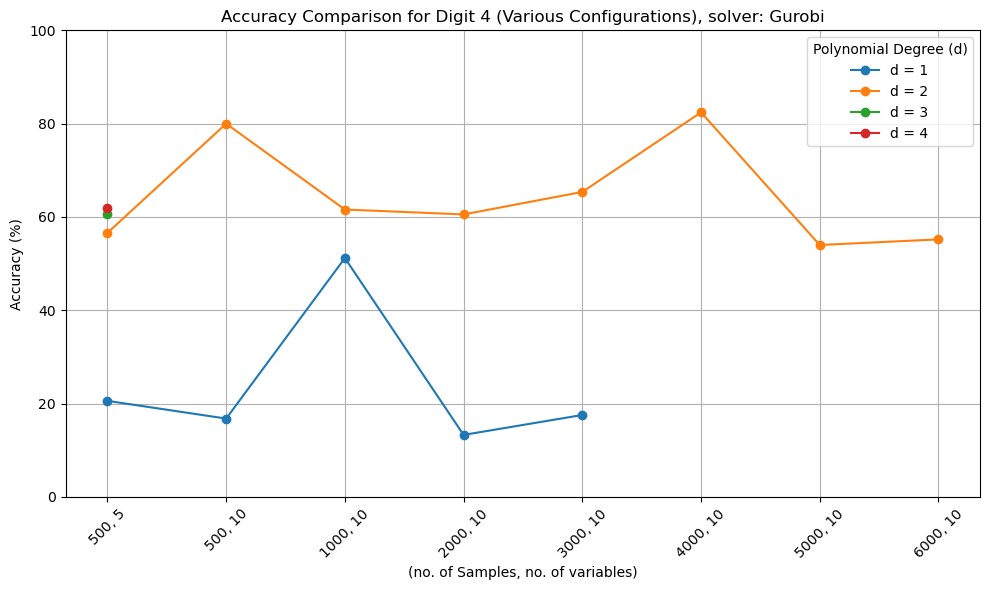

In [90]:
import matplotlib.pyplot as plt

# Data storage for visualization
results = {
    1: {  # d = 1
        (500, 5): 20.60,
        (500, 10): 16.80,
        (1000, 10): 51.20,
        (2000, 10): 13.30,
        (3000, 10): 17.57,
    },
    2: {  # d = 2
        (500, 5): 56.60,
        (500, 10): 80,
        (1000, 10): 61.60,
        (2000, 10): 60.55,
        (3000, 10): 65.37,
        (4000, 10): 82.42,
        (5000, 10): 54,
        (6000, 10): 55.20,
    },
    3: {  # d = 3
        (500, 5): 60.60,
    },
    4: {  # d = 4
        (500, 5): 62.00,
    },
}

# Visualization function
def plot_results(results):
    plt.figure(figsize=(10, 6))
    for d, values in results.items():
        samples_components = list(values.keys())
        accuracies = list(values.values())
        labels = [f"{samples}, {components}" for samples, components in samples_components]

        # Plot each degree d
        plt.plot(labels, accuracies, marker='o', label=f"d = {d}")

    # Add plot details
    plt.title("Accuracy Comparison for Digit 4 (Various Configurations), solver: Gurobi")
    plt.xlabel("(no. of Samples, no. of variables)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Polynomial Degree (d)")
    plt.tight_layout()
    plt.show()

# Plot the results
plot_results(results)


Computation Time Plot

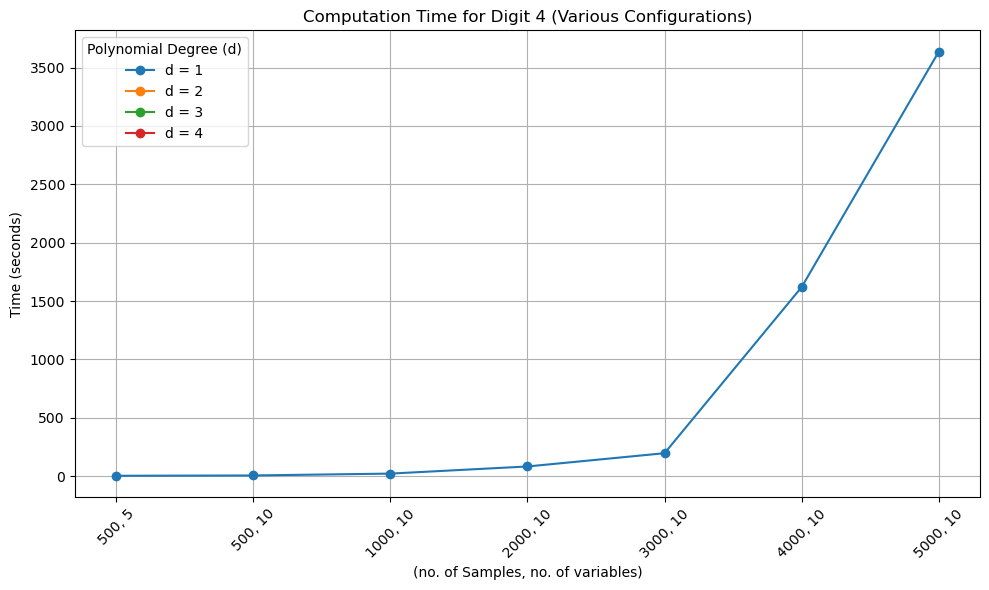

In [91]:
import matplotlib.pyplot as plt

# Data storage for computation time
results_time = {
    1: {  # d = 1
        (500, 5): 4.30,
        (500, 10): 6.98,
        (1000, 10): 22.83,
        (2000, 10): 83.89,
        (3000, 10): 197.56,
        (4000, 10): 1620.75,
        (5000, 10): 2507.89,
        (5000, 10): 3637.21,
    },
    2: {  # d = 2
        #(500, 5): 2.5,

    },
    3: {  # d = 3
        #(500, 5): 3.5,
    },
    4: {  # d = 4
        #(500, 5): 4.0,
    },
}

# Visualization function for computation time
def plot_computation_time(results_time):
    plt.figure(figsize=(10, 6))
    for d, values in results_time.items():
        samples_components = list(values.keys())
        runtimes = list(values.values())
        labels = [f"{samples}, {components}" for samples, components in samples_components]

        # Plot each degree d
        plt.plot(labels, runtimes, marker='o', label=f"d = {d}")

    # Add plot details
    plt.title("Computation Time for Digit 4 (Various Configurations)")
    plt.xlabel("(no. of Samples, no. of variables)")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Polynomial Degree (d)")
    plt.tight_layout()
    plt.show()

# Plot the computation time
plot_computation_time(results_time)